# Problem Description

classify whether the person in the image is wearing glasses or not .Dataset is from https://www.kaggle.com/aniruddha123/glasses-data .

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense,Conv2D,Activation,Flatten,MaxPooling2D

## EDA

* Identifying Class Imbalance

In [2]:
images = []
list_class = ['glass','no-glass']
select_random = []

for i in range(2):
    
    class_path = os.path.join(os.getcwd(),'train',list_class[i])
    
    images.append([ fn for fn in os.listdir(class_path)]) 

    select_random.append( np.random.choice(images[i], 3, replace = False))

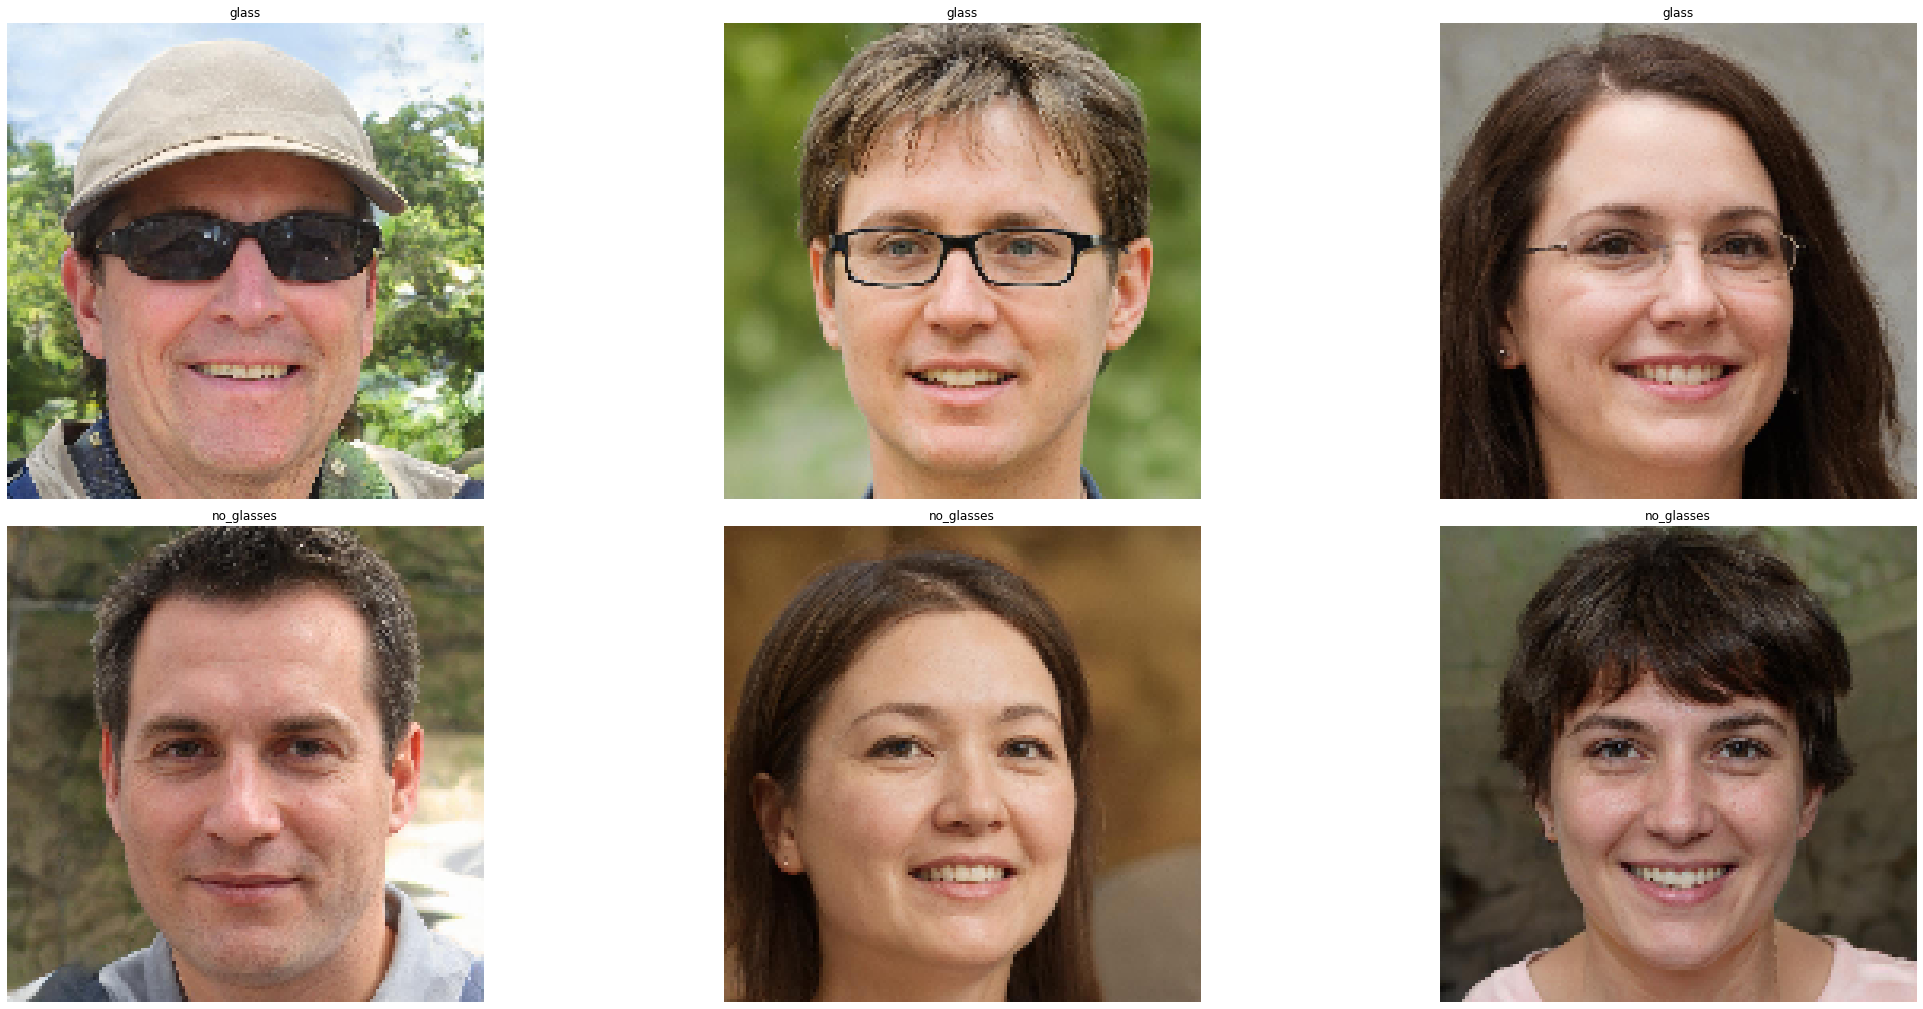

In [3]:
fig = plt.figure(figsize = (30,70))

num = 1

list_label = ['glass','no_glasses']

for i in range(2):
    for j in range(3):
        
        label = list_label[i]
        
        class_path = os.path.join(os.getcwd(),'train',list_class[i])
        
        ax = fig.add_subplot(10, 3, num)
            
        fn = image.load_img(os.path.join(class_path,select_random[i][j]), target_size = (150,150))
        
        plt.imshow(fn)
        plt.title(label)
        plt.axis('off')
        
        num+=1

        
plt.tight_layout()

From what i see :

* Generally image has the face in center , but face maybe not facing to the person that taking the photo
* Some glasses have frame that not quite easy to see like 'face-341' in glasses folder . Some glass have different color(that is not clear like 'face-3') like 'face-2','face-17'

In [4]:
number_classes = {}

for i in range(2):
    class_name = list_class[i]
    
    path_name = os.path.join( os.getcwd() ,"train", class_name )
    
    number_classes[class_name] = len(os.listdir(path_name))

Text(0, 0.5, 'number of image')

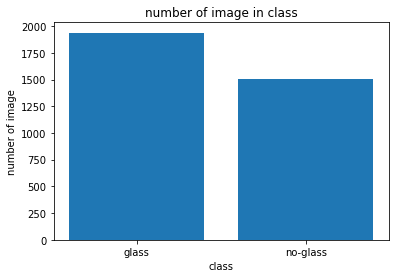

In [5]:
plt.bar(number_classes.keys() , number_classes.values()  )

plt.title('number of image in class')
plt.xlabel('class')
plt.ylabel('number of image')

In [6]:
directories = {}

for i in range(2):
    
    class_name = list_class[i]
    
    path_name = os.path.join( os.getcwd() ,"train" , class_name )
    
    directories[class_name] = path_name

def get_dims(file):
    
    """ Returns dimensions for an RBG image """
    
    im = Image.open(file)
    
    arr = np.array(im)
    
    h,w,d = arr.shape
    
    return h,w

def generate_df_dims(class_path):
    df_dum = []
    
    filelist = [os.path.join(class_path,f) for f in os.listdir(class_path)]
        
    for pic_path in filelist:
        
        h,w = get_dims(pic_path)
        
        df_dum.append((h,w))
        
    return pd.DataFrame(df_dum,columns=['h','w'])
    

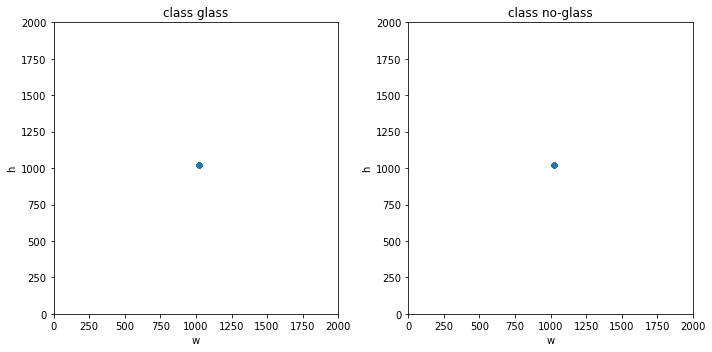

In [18]:
fig, axs = plt.subplots(1, 2,figsize=(10, 5))

num = 0

for j in range(2):
        
    name = list_class[j]

    df_dum = generate_df_dims(directories[name])

    df_dum.plot.scatter(x='w', y='h',ax = axs[j]);

    axs[j].set_title('class'+' '+list_class[j])
    axs[j].set_ylim(0,2000)
    axs[j].set_xlim(0,2000)

    num+=1

# plt.title('Image size in each class')
plt.tight_layout()
        


In [9]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = os.path.join(path,fn)
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

train_dir = os.path.join(os.getcwd(),'train')

glass_imgs = [fn for fn in os.listdir(f'{train_dir}/glass') ]
no_glass_imgs = [fn for fn in os.listdir(f'{train_dir}/no-glass') ]

# run it on our folders

glass_images = img2np(os.path.join(train_dir,'glass'),glass_imgs)
no_glass_images = img2np(os.path.join(train_dir,'no-glass'),no_glass_imgs)

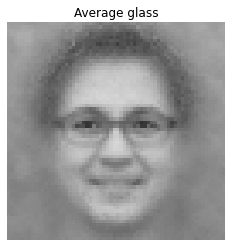

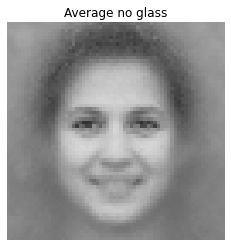

In [12]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

glass_mean = find_mean_img(glass_images, 'glass')
no_glass_mean = find_mean_img(no_glass_images, 'no glass')

Area around eye shape a glasses for average glass

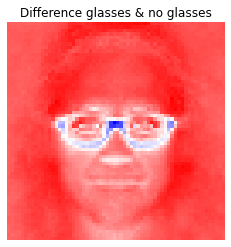

In [14]:
contrast_mean = glass_mean - no_glass_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference glasses & no glasses')
plt.axis('off')
plt.show()

Difference between glass and no glass seen on area around eye , as expected , that shape glasses

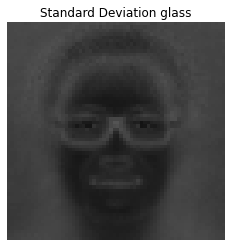

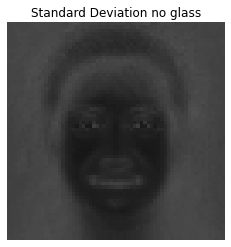

In [16]:
def find_std_img(full_mat, title, size = (64, 64)):
    # calculate the average
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

glass_std = find_std_img(glass_images, 'glass')
no_glass_std = find_std_img(no_glass_images, 'no glass')

Picture with glasses show much variability(shown by lighter color) around eye

In [3]:
def make_model_v1(size , learning_rate = 0.01 ):
    """Beginning of Model Architecture"""
    
    model = keras.models.Sequential()

    # specify convolutional layer 

    # convolutional layer 1
    model.add(Conv2D(filters = 32,kernel_size = (3,3),input_shape = (size[0],size[1],3) ,activation = 'relu' ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # convolutional layer 2
    model.add(Conv2D(filters = 32,kernel_size = (3,3) , activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # make a feature vector
    model.add(Flatten())

    # dense layer

    # hidden layer 1
    model.add(Dense(10 , activation = 'relu'))

    # output layer
    model.add(Dense(1, activation = 'sigmoid') )

    """End of Model architecture"""

    """
    optimizer
    """

    # SGD 

    optimizer = tf.keras.optimizers.SGD(learning_rate  = learning_rate , momentum = 0.8)

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])

    
    return model


In [4]:
# Make generator for training and validation data

size = (299,299)


train_gen = ImageDataGenerator(
    rescale=1./255
)

train_ds = train_gen.flow_from_directory(
    './train/',
    target_size = size,
    batch_size = 20,
    class_mode = 'binary',
    shuffle = True 
)

val_gen = ImageDataGenerator(
    rescale=1./255
)

val_ds = val_gen.flow_from_directory(
    './val',
    target_size = size,
    batch_size = 20,
    class_mode = 'binary',
    shuffle = False
)

Found 3443 images belonging to 2 classes.
Found 737 images belonging to 2 classes.


In [5]:
scores = {}

for lr in [0.0001 , 0.001 , 0.01 , 0.1]:
    
    # define checkpoint for every learning rate
    filename = 'model_v1_{epoch:02d}_{val_accuracy:.3f}.h5'
    filepath = os.path.join(os.getcwd(),'checkpoint','model_v1',f'lr={lr}',filename)
    
    checkpoint =keras.callbacks.ModelCheckpoint(
    filepath ,
    save_best_only=False,
    monitor = 'val_accuracy',
    mode = 'max' ,
    save_freq = 'epoch'
)
    
    model=make_model_v1(size=size,learning_rate = lr)
    history = model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks = [checkpoint])
    scores[lr] = history.history
    

Epoch 1/10
173/173 [==============================] - 166s 962ms/step - loss: 0.6685 - accuracy: 0.5800 - val_loss: 0.6470 - val_accuracy: 0.6486
Epoch 2/10
173/173 [==============================] - 270s 2s/step - loss: 0.6268 - accuracy: 0.6820 - val_loss: 0.6071 - val_accuracy: 0.6839
Epoch 3/10
173/173 [==============================] - 309s 2s/step - loss: 0.5810 - accuracy: 0.7462 - val_loss: 0.5534 - val_accuracy: 0.7571
Epoch 4/10
173/173 [==============================] - 338s 2s/step - loss: 0.5326 - accuracy: 0.7790 - val_loss: 0.5040 - val_accuracy: 0.8087
Epoch 5/10
173/173 [==============================] - 371s 2s/step - loss: 0.4789 - accuracy: 0.8179 - val_loss: 0.4486 - val_accuracy: 0.8385
Epoch 6/10
173/173 [==============================] - 321s 2s/step - loss: 0.4246 - accuracy: 0.8458 - val_loss: 0.3905 - val_accuracy: 0.8765
Epoch 7/10
173/173 [==============================] - 300s 2s/step - loss: 0.3694 - accuracy: 0.8809 - val_loss: 0.3324 - val_accuracy: 0.9

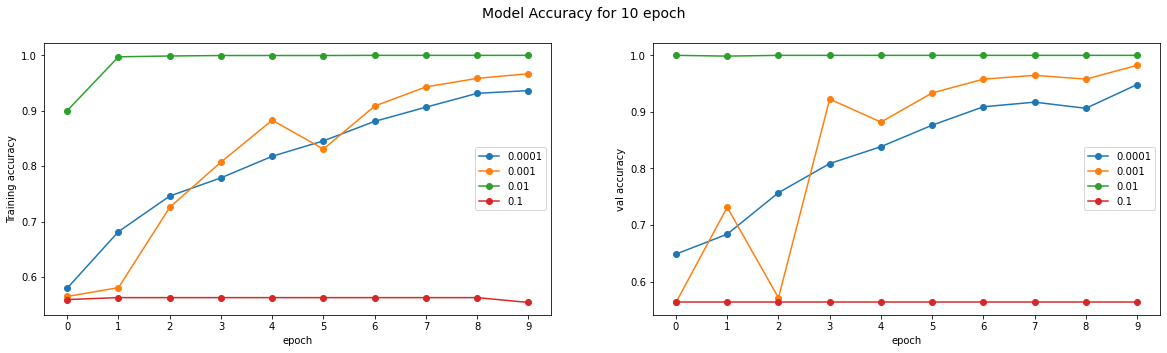

In [41]:
fig, axs = plt.subplots(1, 2,figsize=(20, 5))

for lr,hist in scores.items():
    axs[0].plot(hist['accuracy'],label = lr,marker='o')
    axs[0].legend(loc='best')
    axs[0].set_ylabel('Training accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].set_xticks(np.arange(10))

    axs[1].plot(hist['val_accuracy'],label = lr,marker='o')
    axs[1].legend(loc='best')
    axs[1].set_ylabel('val accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].set_xticks(np.arange(10))

plt.suptitle("Model Accuracy for 10 epoch", fontsize=14)
plt.show()

I feel for this model , 
* With learning rate 0.01 , the model is overfitting
* With learning rate 0.1 , the model is underfitting

So i try to fit more epoch on model with learning rate 0.001 and 0.0001

In [53]:
model_a = keras.models.load_model('model_v1_10_0.948.h5') # for learning rate 0.0001
model_b = keras.models.load_model('model_v1_10_0.982.h5')  # for learning rate 0.001

In [54]:
# for model_a
scores = {}

filename = 'model_v1_morepoch_{epoch:02d}_{val_accuracy:.3f}.h5'
filepath = os.path.join(os.getcwd(),'checkpoint','model_v1_moreepoch','lr=0.0001',filename)

checkpoint =keras.callbacks.ModelCheckpoint(
    filepath ,
    save_best_only=False,
    monitor = 'val_accuracy',
    mode = 'max' ,
    save_freq = 'epoch'
)

history = model_a.fit(train_ds,epochs=10,validation_data=val_ds,callbacks = [checkpoint])
lr =0.0001
scores[lr] = history.history
    

Epoch 1/10
173/173 [==============================] - 310s 2s/step - loss: 0.2065 - accuracy: 0.9471 - val_loss: 0.1978 - val_accuracy: 0.9322
Epoch 2/10
173/173 [==============================] - 354s 2s/step - loss: 0.1824 - accuracy: 0.9532 - val_loss: 0.1830 - val_accuracy: 0.9552
Epoch 3/10
173/173 [==============================] - 288s 2s/step - loss: 0.1651 - accuracy: 0.9559 - val_loss: 0.1617 - val_accuracy: 0.9579
Epoch 4/10
173/173 [==============================] - 282s 2s/step - loss: 0.1502 - accuracy: 0.9605 - val_loss: 0.1533 - val_accuracy: 0.9566
Epoch 5/10
173/173 [==============================] - 308s 2s/step - loss: 0.1353 - accuracy: 0.9637 - val_loss: 0.1653 - val_accuracy: 0.9335
Epoch 6/10
173/173 [==============================] - 299s 2s/step - loss: 0.1345 - accuracy: 0.9646 - val_loss: 0.1497 - val_accuracy: 0.9457
Epoch 7/10
173/173 [==============================] - 284s 2s/step - loss: 0.1145 - accuracy: 0.9657 - val_loss: 0.1147 - val_accuracy: 0.9715

In [55]:
# for model_b

filename = 'model_v1_morepoch_{epoch:02d}_{val_accuracy:.3f}.h5'
filepath = os.path.join(os.getcwd(),'checkpoint','model_v1_moreepoch','lr=0.001',filename)

checkpoint =keras.callbacks.ModelCheckpoint(
    filepath ,
    save_best_only=False,
    monitor = 'val_accuracy',
    mode = 'max' ,
    save_freq = 'epoch'
)

history = model_b.fit(train_ds,epochs=10,validation_data=val_ds,callbacks = [checkpoint])
lr =0.001
scores[lr] = history.history
    


Epoch 1/10
173/173 [==============================] - 254s 1s/step - loss: 0.0838 - accuracy: 0.9727 - val_loss: 0.0688 - val_accuracy: 0.9796
Epoch 2/10
173/173 [==============================] - 303s 2s/step - loss: 0.0669 - accuracy: 0.9776 - val_loss: 0.0565 - val_accuracy: 0.9837
Epoch 3/10
173/173 [==============================] - 256s 1s/step - loss: 0.0530 - accuracy: 0.9837 - val_loss: 0.0588 - val_accuracy: 0.9824
Epoch 4/10
173/173 [==============================] - 246s 1s/step - loss: 0.0488 - accuracy: 0.9846 - val_loss: 0.0680 - val_accuracy: 0.9769
Epoch 5/10
173/173 [==============================] - 245s 1s/step - loss: 0.0365 - accuracy: 0.9895 - val_loss: 0.0520 - val_accuracy: 0.9851
Epoch 6/10
173/173 [==============================] - 244s 1s/step - loss: 0.0332 - accuracy: 0.9907 - val_loss: 0.0454 - val_accuracy: 0.9891
Epoch 7/10
173/173 [==============================] - 243s 1s/step - loss: 0.0249 - accuracy: 0.9939 - val_loss: 0.0778 - val_accuracy: 0.9674

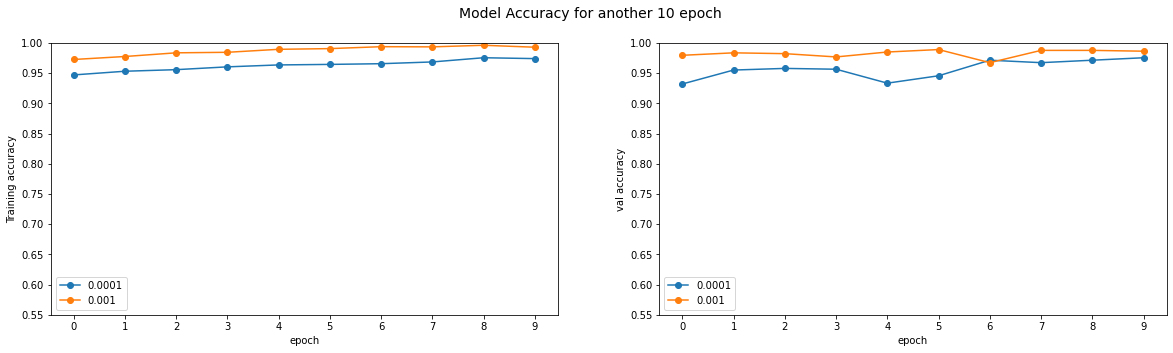

In [57]:
fig, axs = plt.subplots(1, 2,figsize=(20, 5))

for lr,hist in scores.items():
    axs[0].plot(hist['accuracy'],label = lr,marker='o')
    axs[0].legend(loc='best')
    axs[0].set_ylabel('Training accuracy')
    axs[0].set_ylim((0.55,1))
    axs[0].set_xlabel('epoch')
    axs[0].set_xticks(np.arange(10))

    axs[1].plot(hist['val_accuracy'],label = lr,marker='o')
    axs[1].legend(loc='best')
    axs[1].set_ylabel('val accuracy')
    axs[1].set_ylim((0.55,1))
    axs[1].set_xlabel('epoch')
    axs[1].set_xticks(np.arange(10))

plt.suptitle("Model Accuracy for another 10 epoch", fontsize=14)
plt.show()

In [58]:
# Performance on test dataset

size = (299,299)


test_gen = ImageDataGenerator(
    rescale=1./255
)

test_ds = test_gen.flow_from_directory(
    './test/',
    target_size = size,
    batch_size = 20,
    class_mode = 'binary',
    shuffle = False
)

Found 740 images belonging to 2 classes.


In [59]:
# for model a
model_a.evaluate(test_ds)

37/37 [==============================] - 40s 1s/step - loss: 0.0863 - accuracy: 0.9797


[0.08630803227424622, 0.9797297120094299]

In [60]:
# for model b
model_b.evaluate(test_ds)

37/37 [==============================] - 37s 990ms/step - loss: 0.0354 - accuracy: 0.9851


[0.03540242463350296, 0.9851351380348206]

I choose model b , that is model_v1 with learning rate 0.001